In [1]:
!pip install clickhouse_driver datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.1/935.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.8 MB/s eta 0:00:00


In [7]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.7/647.7 kB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 82.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 666.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os
import json


from tqdm.auto import tqdm
from clickhouse_driver import Client
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from datasets import Dataset
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

tqdm.pandas()

In [29]:
class ClickHouse:
    def __init__(self, client: Client):
        self.client = client

    def preprocess_images_df(self, images_df, embeddings):
        num_samples = 0 #self.get_num_samples()
        images_df["id"] = [num_samples + k for k in range(0, images_df.shape[0])]
        images_df["embedding"] = embeddings.tolist()
        images_df["path"] = images_df["path"]
        images_df.to_json("images+embeddings.json")

        file_path = "images+embeddings.json"

        with open(file_path, "r", encoding="utf-8") as file:
            data = json.load(file)

        ids = data["id"]
        embeddings = data["embedding"]
        paths = data["path"]

        rows_to_insert = []
        for i in range(len(ids)):
            i_str = str(i)

            row = {
                "id": ids[i_str],
                "path": paths[i_str],
                "embedding": embeddings[i_str],
            }
            rows_to_insert.append(row)

        return rows_to_insert

    def _post_process_images(self, samples):
        samples = list(map(list, samples))
        return samples

    def add(self, df, embeddings):
        print(df)
        insert_info = self.preprocess_images_df(df, embeddings)
        print(insert_info)
        self.client.execute(
            "INSERT INTO images_embeddings_db (id, path, embedding) VALUES",
            insert_info,
        )

    def _click_to_pd_images(self, click_out):
        df = pd.DataFrame(columns=["id", "path",  "cos"], data=click_out)
        return df

    def retrieve(self, embedding, table: str = 'misis.images_embeddings_db', order_by="score", k: int = 1):
        request = f"""
            SELECT
            id
            path,
            cosineDistance(embedding, {str(embedding[0].tolist())}) AS score
            FROM {table}
            ORDER BY {order_by} ASC
            LIMIT {k}
            FORMAT Vertical
            """

        df = self._click_to_pd_images(request)

        return df

    def get_num_samples(self, table: str = "misis.images_embeddings_db"):
        request = f"""
        SELECT COUNT() FROM {table};
        """

        return self.client.execute(request)[0][0]

In [30]:
class Retriever:
    def __init__(
        self,
        model,
        processor,
        clickhouse: ClickHouse,
        image_weigth: float = 0.7,
        text_weight: float = 0.3,
        device: str = "cuda",
    ):
        super().__init__()
        self.device = device

        self.model = model
        self.model.eval()
        self.model.to(self.device)
        self.processor = processor

        self.image_weigth = image_weigth
        self.text_weight = text_weight

        self.clickhouse = clickhouse

    @torch.no_grad
    def get_text_latents(self, texts):
        text_latents = []

        inputs = self.processor(text=texts, return_tensors='pt', padding=True)
        text_latents.append(self.model.encode_text(inputs['input_ids'].to(device)))

        text_latents.append(torch.cat(text_latents, dim=0))
        text_latents = torch.stack(text_latents).mean(0)
        text_latents = text_latents / text_latents.norm(dim=-1, keepdim=True)

        return text_latents

    @torch.no_grad
    def get_image_latents(self, images):
            image_latents = []

            inputs = self.processor(text='', images=list(images), return_tensors='pt', padding=True)
            image_latents.append(self.model.encode_image(inputs['pixel_values'].to(device)))

            image_latents = torch.cat(image_latents)
            image_latents = image_latents / image_latents.norm(dim=-1, keepdim=True)

            return image_latents

    @staticmethod
    def _paths_to_images(paths):
        images = [Image.open(path) for path in paths]
        return images

    def add(self, df, return_embeddings: bool = False):
        paths = df["path"].tolist()
        images = self._paths_to_images(paths)
        embeddings = self.get_image_latents(images)

        torch.cuda.empty_cache()

        self.clickhouse.add(df, embeddings)

        if return_embeddings:
            return embeddings

    def query(self, paths=None, texts=None, k: int = 1):
        if paths is not None and texts is None:
            images = self._paths_to_images(paths)
            embedding = self.get_image_latents(images)

        elif paths is None and texts is not None:
            embedding = self.get_text_latents(texts)

        elif paths is not None and texts is not None:
            images = self._paths_to_images(paths)
            embedding = self.get_image_latents(images)
            text_embeddings = self.get_text_latents(texts)
            embedding = self.image_weight * image_embeddings + self.text_weight * text_embeddings

        else:
            raise ValueError("Either paths of texts should not be equal to None")

        torch.cuda.empty_cache()
        return self.clickhouse.retrieve(embedding, k=k)

    def __len__(self):
        return self.clickhouse.get_num_samples()


In [11]:
cd /content/drive/MyDrive/travel-hack-ml-master

/content/drive/MyDrive/travel-hack-ml-master


In [12]:
import ruclip

device = 'cuda'
clip, processor = ruclip.load('ruclip-vit-base-patch32-384', device=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:655: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


bpe.model:   0%|          | 0.00/748k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/606M [00:00<?, ?B/s]

In [34]:
clickhouse = ClickHouse(client=Client(host='158.160.153.233', port=9000,  password='JX2J59Y4g29A', user='misis_admin', database='misis'))

In [35]:
retriever = Retriever(
    model=clip,
    processor=processor,
    clickhouse=clickhouse,
)

In [26]:
cd /content/drive/MyDrive/Москва. Фото

/content/drive/MyDrive/Москва. Фото


In [27]:
DATA = "/content/drive/MyDrive/Москва. Фото"

paths = [file for file in os.listdir(DATA)]
df = pd.DataFrame({"path": paths[:5]})
df

path
0     Биржевая площадь (2).jpg
1     Биржевая площадь (1).jpg
2    Богоявленский собор.jpeg
3         Биржевая площадь.jpg
4  Богоявленский собор_1.jpeg

In [36]:
retriever.add(df)

                          path  id  \
0     Биржевая площадь (2).jpg   0   
1     Биржевая площадь (1).jpg   1   
2    Богоявленский собор.jpeg   2   
3         Биржевая площадь.jpg   3   
4  Богоявленский собор_1.jpeg   4   

                                           embedding  
0  [0.06320679932832718, -0.003029501298442483, -...  
1  [0.06320679932832718, -0.003029501298442483, -...  
2  [0.0178070105612278, 0.047246310859918594, -0....  
3  [0.06320679932832718, -0.003029501298442483, -...  
4  [0.03177819773554802, 0.028356172144412994, -0...  
[{'id': 0, 'path': 'Биржевая площадь (2).jpg', 'embedding': [0.0632067993, -0.0030295013, -0.0208450146, -0.0100105135, 0.0282008126, 0.0298980344, 0.0130076436, 0.0366601385, 0.0555235669, 0.0483601019, 0.0314479582, -0.0518874452, -0.0146281617, -0.0621892773, -0.0623921007, -0.0578784235, 0.0084001459, 0.014443812, 0.0458253473, -0.0763848126, 0.0661758184, -0.0190354157, -0.0442560352, 0.0914720967, -0.0073045017, -0.0884540677, -0.0

In [ ]:


images = [Image.open(DATA + file) for file in os.listdir(DATA)]

texts = ["Москва Сити",  "Собор василия блаженного", "Патриаршие пруды"]
images[-5]

In [ ]:
@torch.no_grad()
def get_text_latents(texts):
    text_latents = []

    inputs = processor(text=texts, return_tensors='pt', padding=True)
    text_latents.append(clip.encode_text(inputs['input_ids'].to(device)))

    text_latents.append(torch.cat(text_latents, dim=0))
    text_latents = torch.stack(text_latents).mean(0)
    text_latents = text_latents / text_latents.norm(dim=-1, keepdim=True)

    return text_latents

@torch.no_grad()
def get_image_latents(images):
        image_latents = []

        inputs = processor(text='', images=list(images), return_tensors='pt', padding=True)
        image_latents.append(clip.encode_image(inputs['pixel_values'].to(device)))

        image_latents = torch.cat(image_latents)
        image_latents = image_latents / image_latents.norm(dim=-1, keepdim=True)

        return image_latents

In [ ]:
image_latents = get_image_latents(images)
text_latents = get_text_latents(texts)
image_latents.shape, text_latents.shape

(torch.Size([10, 512]), torch.Size([3, 512]))

In [ ]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-08)
cos

CosineSimilarity()

In [ ]:
cos(image_latents, text_latents)

tensor([0.0849, 0.0524, 0.3966, 0.2991], device='cuda:0')

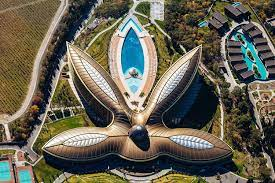

In [ ]:
images[0]

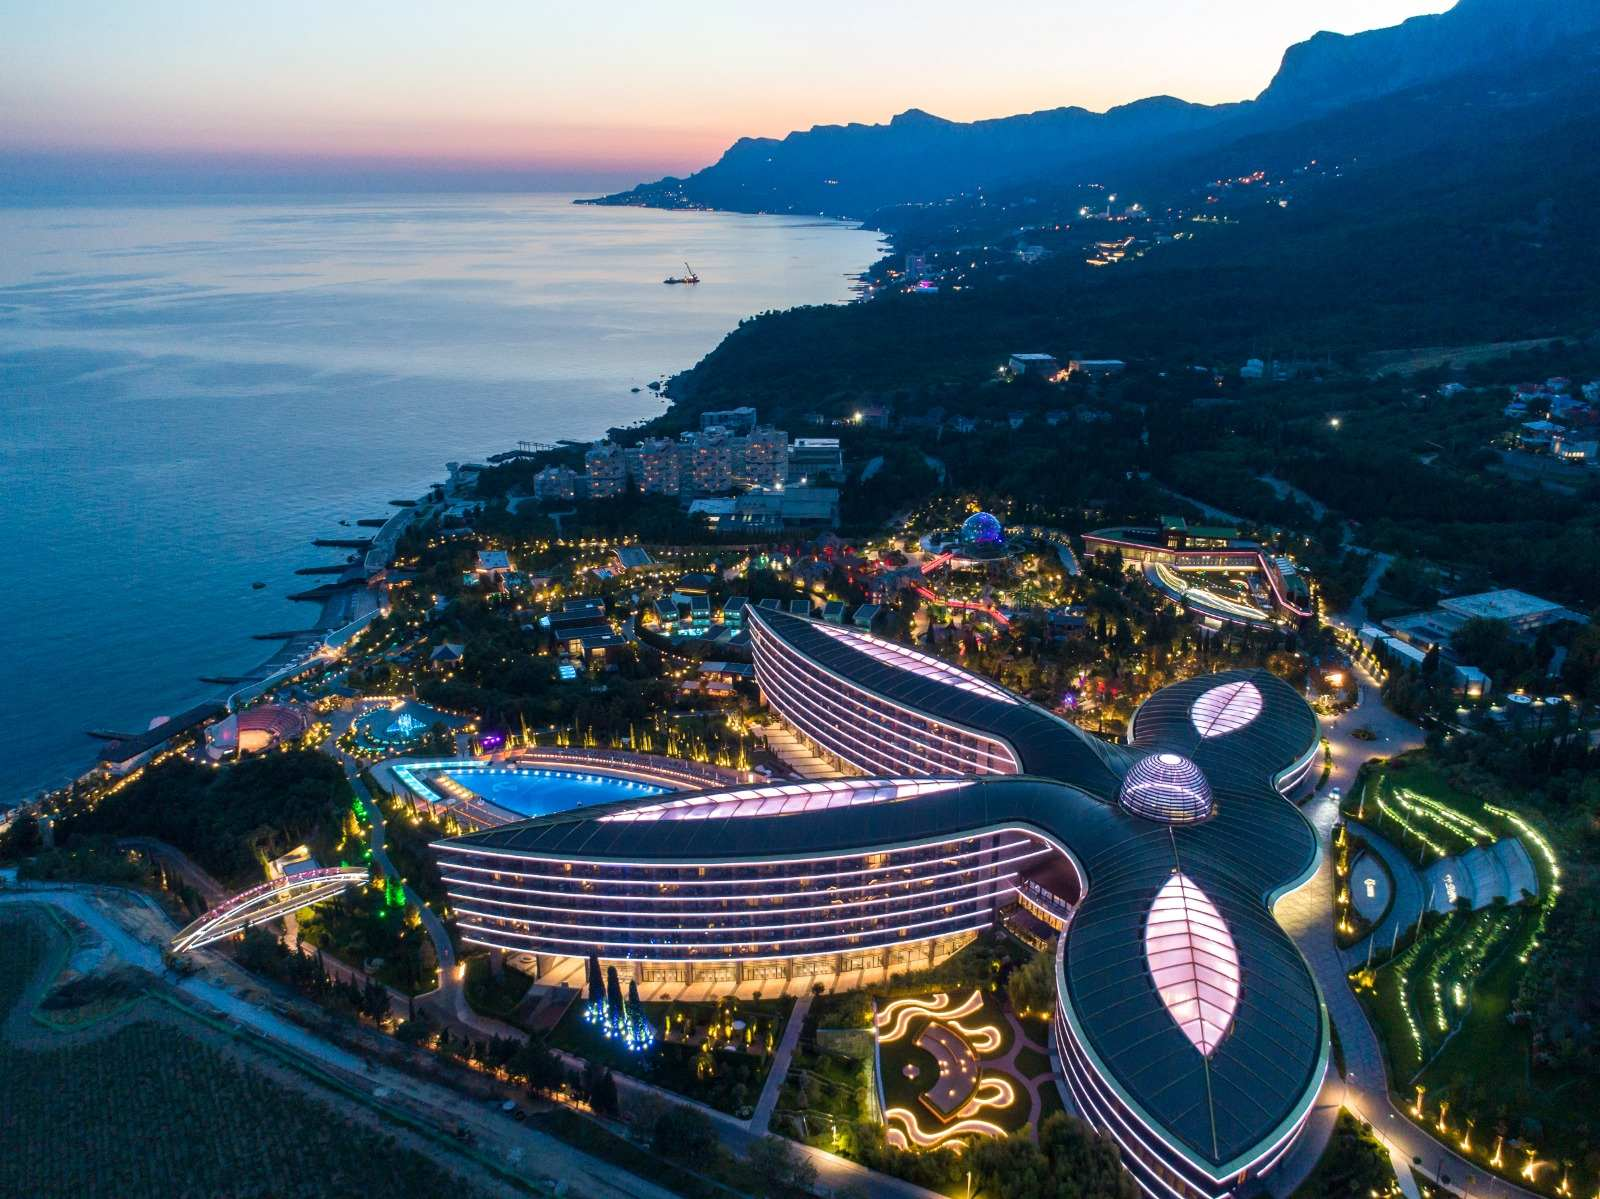

In [ ]:
images[2]

In [ ]:
cos(image_latents[0].unsqueeze(dim=0), image_latents[2].unsqueeze(dim=0))

tensor([0.5216], device='cuda:0')

In [ ]:
cos(image_latents[0].unsqueeze(dim=0), image_latents[3].unsqueeze(dim=0))

tensor([0.4394], device='cuda:0')

In [ ]:
cos(image_latents[2].unsqueeze(dim=0), image_latents[3].unsqueeze(dim=0))

tensor([0.4176], device='cuda:0')